In [ ]:
import zipfile
from pathlib import Path
import re
import numpy as np
import gc
from tqdm import tqdm
zip_path = "/content/processed_test_data.zip"  # <-- Update with your ZIP path
extract_dir = Path("/content/caaddd_extracted")
extract_dir.mkdir(exist_ok=True)

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Data extracted to:", extract_dir)

✅ Data extracted to: /content/caaddd_extracted


In [ ]:

def parse_dat(dat_path):
    """Parse nodal displacements from .dat file."""
    displacements = []
    inside_node_output = False

    with open(dat_path) as f:
        for line in f:
            if "N O D E   O U T P U T" in line.upper():
                inside_node_output = True
                continue
            if inside_node_output:
                if "MAXIMUM" in line.upper() or "MINIMUM" in line.upper():
                    break
                if not line.strip():
                    continue
                if "NODE" in line.upper() and "U1" in line.upper():
                    continue
                if re.match(r"^\s*\d+", line):
                    parts = line.split()
                    node_id = int(parts[0])
                    values = list(map(float, parts[2:]))  # skip FOOT- column
                    displacements.append([node_id] + values)

    displacements = np.array(displacements, dtype=np.float32)
    return displacements
# Example usage
# Example usage
dat_file = "/content/caaddd_extracted/processed_test_data/Varient_1/test_1.dat"
displacements = parse_dat(dat_file)

print("Number of nodes with displacement:", len(displacements))
print("First 5 nodal displacements:\n", displacements[:5])

Number of nodes with displacement: 6
First 5 nodal displacements:
 [[ 2.          0.63913083 -0.80421     0.18421787  0.          0.        ]
 [ 3.          0.12584937 -0.2901807   0.10837966  0.          0.        ]
 [ 4.          0.82453775  0.921265    0.31876263  0.          0.        ]
 [ 5.          0.18547948 -0.3763333   0.13411954  0.          0.        ]
 [ 7.          0.06857149  0.13421406  0.11500238  0.          0.        ]]


In [3]:
def parse_inp(inp_path):
    """Parse nodes, elements, and boundary conditions from .inp file."""
    nodes = {}
    elements = []
    bcs = []
    with open(inp_path, 'r') as f:
        lines = f.readlines()

    mode = None
    for line in lines:
        line = line.strip()
        if line.lower().startswith("*node"):
            mode = "node"
            continue
        elif line.lower().startswith("*element"):
            mode = "element"
            continue
        elif line.lower().startswith("*boundary"):
            mode = "bc"
            continue
        elif line.startswith("*"):
            mode = None
            continue

        if mode == "node":
            parts = line.split(",")
            if len(parts) >= 4:
                nodes[int(parts[0])] = tuple(map(float, parts[1:4]))
        elif mode == "element":
            parts = line.split(",")
            if len(parts) >= 2:
                elements.append((int(parts[0]), tuple(map(int, parts[1:]))))
        elif mode == "bc":
            parts = [p.strip() for p in line.split(",")]
            bcs.append(parts)  # keep as strings

    return nodes, elements, bcs
inp_file = "/content/caaddd_extracted/processed_test_data/Varient_1/test_1.inp"
nodes, elements, bcs = parse_inp(inp_file)
print("Number of nodes:", len(nodes))
print("Number of elements:", len(elements))
print("Number of BCs:", len(bcs))
print("First 5 BCs:", bcs[:5])


Number of nodes: 9
Number of elements: 4
Number of BCs: 1
First 5 BCs: [['DOF_3', '1', '6']]


In [4]:
import os
import numpy as np

base_path = "/content/caaddd_extracted/processed_test_data"

all_data = []

variant_folders = [f for f in os.listdir(base_path) if f.startswith("Varient_")]
variant_folders.sort()

for var_folder in variant_folders:
    var_path = os.path.join(base_path, var_folder)
    test_file_number = var_folder.split("_")[1]  # x in Varient_x
    inp_file = os.path.join(var_path, f"test_{test_file_number}.inp")
    dat_file = os.path.join(var_path, f"test_{test_file_number}.dat")

    # Parse files
    nodes, elements, bcs = parse_inp(inp_file)
    displacements = parse_dat(dat_file)

    variant_data = {
        "variant": var_folder,
        "nodes": nodes,
        "elements": elements,
        "bcs": bcs,
        "displacements": displacements
    }

    all_data.append(variant_data)


print(f"Processed {len(all_data)} variants.")
print("Example from first variant:")
print("Nodes:", len(all_data[0]["nodes"]))
print("Elements:", len(all_data[0]["elements"]))
print("BCs:", all_data[0]["bcs"])
print("Displacements:\n", all_data[0]["displacements"][:5])


Processed 2117 variants.
Example from first variant:
Nodes: 9
Elements: 4
BCs: [['DOF_3', '1', '6']]
Displacements:
 [[ 2.          0.63913083 -0.80421     0.18421787  0.          0.        ]
 [ 3.          0.12584937 -0.2901807   0.10837966  0.          0.        ]
 [ 4.          0.82453775  0.921265    0.31876263  0.          0.        ]
 [ 5.          0.18547948 -0.3763333   0.13411954  0.          0.        ]
 [ 7.          0.06857149  0.13421406  0.11500238  0.          0.        ]]


In [24]:
import torch
from torch_geometric.data import Data

graph_data_list = []

for variant in all_data:
    nodes = variant['nodes']
    elements = variant['elements']
    displacements = variant['displacements']

    # Node features: x, y, z coordinates
    node_ids = sorted(nodes.keys())
    node_features = torch.tensor([nodes[n] for n in node_ids], dtype=torch.float32)

    # Build edges from elements (connect each node in an element to every other node in the same element)
    edge_index = []
    for elem_id, elem_nodes in elements:
        elem_nodes = [node_ids.index(n) for n in elem_nodes]  # map to 0-based index
        for i in range(len(elem_nodes)):
            for j in range(len(elem_nodes)):
                if i != j:
                    edge_index.append([elem_nodes[i], elem_nodes[j]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # shape [2, num_edges]

    # Target displacements (u_x, u_y, u_z)
    target_nodes = {int(d[0]): d[1:4] for d in displacements}
    y = torch.tensor([target_nodes.get(n, [0.0, 0.0, 0.0]) for n in node_ids], dtype=torch.float32)

    # Create PyG Data object
    graph = Data(x=node_features, edge_index=edge_index, y=y)
    graph_data_list.append(graph)

print(f"Converted {len(graph_data_list)} variants to graph format.")
print("Example graph:", graph_data_list[0])


Converted 2117 variants to graph format.
Example graph: Data(x=[9, 3], edge_index=[2, 48], y=[9, 3])


In [25]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Split dataset
train_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)

# Create loaders
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=16)


In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNModel(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=3, num_layers=3):
        super(GCNModel, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)  # no activation on last layer
        return x


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    total_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch:03d}, Loss: {total_loss:.6f}")


Epoch 001, Loss: 8.030610
Epoch 002, Loss: 2.542574
Epoch 003, Loss: 2.547100
Epoch 004, Loss: 2.547658
Epoch 005, Loss: 2.550890
Epoch 006, Loss: 2.550662
Epoch 007, Loss: 2.548789
Epoch 008, Loss: 2.550352
Epoch 009, Loss: 2.557359
Epoch 010, Loss: 2.554187
Epoch 011, Loss: 2.546168
Epoch 012, Loss: 2.556243
Epoch 013, Loss: 2.572079
Epoch 014, Loss: 2.551176
Epoch 015, Loss: 2.569458
Epoch 016, Loss: 2.558362
Epoch 017, Loss: 2.552132
Epoch 018, Loss: 2.557423
Epoch 019, Loss: 2.559428
Epoch 020, Loss: 2.555340
Epoch 021, Loss: 2.562071
Epoch 022, Loss: 2.560260
Epoch 023, Loss: 2.555637
Epoch 024, Loss: 2.560877
Epoch 025, Loss: 2.566703
Epoch 026, Loss: 2.570681
Epoch 027, Loss: 2.558802
Epoch 028, Loss: 2.560418
Epoch 029, Loss: 2.558269
Epoch 030, Loss: 2.567766
Epoch 031, Loss: 2.563500
Epoch 032, Loss: 2.555203
Epoch 033, Loss: 2.560730
Epoch 034, Loss: 2.549628
Epoch 035, Loss: 2.557787
Epoch 036, Loss: 2.566765
Epoch 037, Loss: 2.562226
Epoch 038, Loss: 2.563085
Epoch 039, L

In [32]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        test_loss += loss.item() * batch.num_graphs
test_loss /= len(test_loader.dataset)
print("Test MSE:", test_loss)


Test MSE: 0.32221777427871273


In [33]:
# Function to convert .inp file to PyG graph (like training)
def inp_to_graph(inp_file):
    nodes, elements, _ = parse_inp(inp_file)
    node_ids = list(nodes.keys())
    x = torch.tensor([nodes[n] for n in node_ids], dtype=torch.float32)

    # Build edges
    edge_index = []
    for e_id, conn in elements:
        for i in range(len(conn)):
            for j in range(i+1, len(conn)):
                edge_index.append([conn[i]-1, conn[j]-1])  # zero-based indexing
                edge_index.append([conn[j]-1, conn[i]-1])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return x, edge_index, node_ids

# Example prediction
new_inp = "/content/caaddd_extracted/processed_test_data/Varient_2/test_2.inp"
x, edge_index, node_ids = inp_to_graph(new_inp)
x, edge_index = x.to(device), edge_index.to(device)

model.eval()
with torch.no_grad():
    pred_disp = model(x, edge_index)

# Convert to numpy array
pred_disp = pred_disp.cpu().numpy()
for nid, disp in zip(node_ids, pred_disp):
    print(f"Node {nid}: Predicted displacement = {disp}")


Node 1: Predicted displacement = [ 0.00545533 -0.08398306  0.02273622]
Node 2: Predicted displacement = [ 0.02972626 -0.23674116 -0.01082707]
Node 3: Predicted displacement = [ 0.02265701 -0.2577084   0.01535495]
Node 4: Predicted displacement = [ 0.04158632 -0.1606797  -0.00671197]
Node 5: Predicted displacement = [-0.00409358 -0.15872067 -0.00469092]
Node 6: Predicted displacement = [-0.01655163 -0.02664034  0.0040368 ]
Node 7: Predicted displacement = [ 0.03917724 -0.16183293  0.01639831]
Node 8: Predicted displacement = [ 0.02335797 -0.03120978  0.02321048]
Node 9: Predicted displacement = [ 0.00711401 -0.160526   -0.02389462]


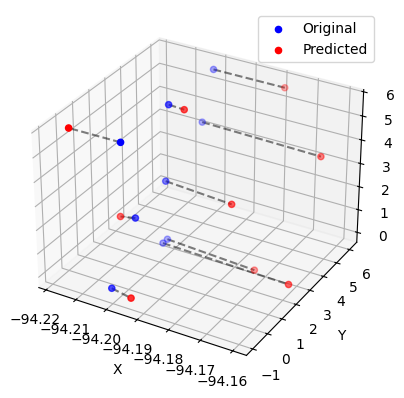

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Original node positions
nodes, _, _ = parse_inp(new_inp)
node_coords = np.array([nodes[n] for n in node_ids])
pred_disp = np.array(pred_disp)

# Plot original and displaced mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(node_coords[:,0], node_coords[:,1], node_coords[:,2], c='b', label='Original')
ax.scatter(node_coords[:,0]+pred_disp[:,0],
           node_coords[:,1]+pred_disp[:,1],
           node_coords[:,2]+pred_disp[:,2], c='r', label='Predicted')

for i in range(len(node_ids)):
    ax.plot([node_coords[i,0], node_coords[i,0]+pred_disp[i,0]],
            [node_coords[i,1], node_coords[i,1]+pred_disp[i,1]],
            [node_coords[i,2], node_coords[i,2]+pred_disp[i,2]], 'k--', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()



In [35]:
import torch

# Assume your model is named `model`
model_save_path = "/content/surrogate_model.pth"

# Save the model state_dict
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at {model_save_path}")


Model saved at /content/surrogate_model.pth
